In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

import wrangle as w
import evaluate as ev

import warnings
warnings.filterwarnings('ignore')

# Exercises
## 1. Load your zillow dataset

In [2]:
df = w.wrangle_zillow()

csv file found and read


In [3]:
train, validate, test = w.split_function(df)
train.head()

Prepared df: (2033172, 9)

Train: (1219902, 9)
Validate: (406635, 9)
Test: (406635, 9)


,bedrooms,bathrooms,square_feet,year_built,tax_amount,county,tax_value,county_Orange,county_Ventura
789918,2,1.0,777,1946,4230,LA,350556,0,0
1696225,2,1.0,1014,1938,2567,LA,192599,0,0
1720742,3,2.0,1762,1958,5566,Orange,480000,1,0
962447,1,1.0,616,1952,1694,LA,131512,0,0
324076,3,2.0,1495,1954,1064,LA,84031,0,0


In [4]:
to_scale = ['bedrooms', 'bathrooms', 'square_feet', 'year_built', 'tax_amount']

In [5]:
train_scaled, validate_scaled, test_scaled = w.get_minmax_scaled(train, validate, test, to_scale)
train_scaled.head()

,bedrooms,bathrooms,square_feet,year_built,tax_amount,county,tax_value,county_Orange,county_Ventura
789918,0.1250,0.05,0.032041,0.674419,0.042016,LA,350556,0,0
1696225,0.1250,0.05,0.041827,0.637209,0.025447,LA,192599,0,0
1720742,0.1875,0.10,0.072712,0.730233,0.055328,Orange,480000,1,0
962447,0.0625,0.05,0.025393,0.702326,0.016749,LA,131512,0,0
324076,0.1875,0.10,0.061687,0.711628,0.010472,LA,84031,0,0


## 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tax_value using only square_feet. 

In [6]:
# first time, I will use the non-scaled train, just to see. then later use the scaled

# make the thing
lr = LinearRegression()

# fit the thing
lr.fit(train[['square_feet']], train.tax_value)

LinearRegression()

In [7]:
yhat = lr.predict(train[['square_feet']])

## 3. Plot the residuals for the linear regression model that you made.

In [8]:
# I'm going to make a new dataframe for this portion with only one independent variable and the target
eval_df = train[['square_feet', 'tax_value']]
eval_df.head()

,square_feet,tax_value
789918,777,350556
1696225,1014,192599
1720742,1762,480000
962447,616,131512
324076,1495,84031


In [9]:
baseline = eval_df.tax_value.mean()
baseline

363190.42289626546

In [10]:
# make some columns for metrics calculations/plotting
eval_df['yhat_baseline'] = eval_df['tax_value'].mean()
eval_df['yhat'] = yhat
eval_df['residual'] = eval_df['yhat'] - eval_df['tax_value']
eval_df['residual_baseline'] = eval_df['yhat_baseline'] - eval_df['tax_value']
eval_df.head()

,square_feet,tax_value,yhat_baseline,yhat,residual,residual_baseline
789918,777,350556,363190.422896,192221.707839,-158334.292161,12634.422896
1696225,1014,192599,363190.422896,233804.058737,41205.058737,170591.422896
1720742,1762,480000,363190.422896,365042.870852,-114957.129148,-116809.577104
962447,616,131512,363190.422896,163973.781702,32461.781702,231678.422896
324076,1495,84031,363190.422896,318196.931233,234165.931233,279159.422896


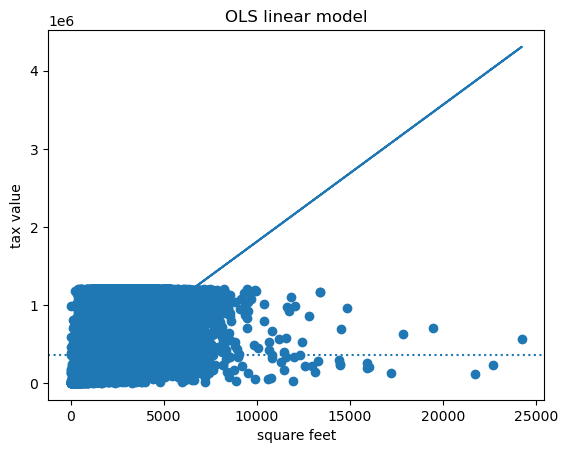

In [11]:
# plotting feature vs target, plus the baseline, plus the predicted line for non-scaled data

plt.scatter(eval_df.square_feet, eval_df.tax_value)
plt.axhline(baseline, ls=':')
plt.plot(eval_df.square_feet, eval_df.yhat)

plt.title('OLS linear model')
plt.xlabel('square feet')
plt.ylabel('tax value')
plt.show()

## Looks like this model might be more accurate if square_feet is < 10000.

## Now, I will do all of this for the scaled dataset

In [ ]:
# make a function to plot x, y, target mean, yhat
def get_feature_target_plot(df):
    """
    This function will
    - accept a dataframe with columns x, y, yhat (should be all continuous variables)
        - x = independent variable
        - y = target variable
        - yhat = predicted y value from some model
    - plots data (scatterplot), baseline (mean of target), and predicted line (yhat)
    """
    cols = df.columns
    
    new_df = df.copy()
    new_df.columns=['x','y','yhat']

    baseline = new_df.y.mean()
    
    plt.scatter(new_df.x, new_df.y)
    plt.axhline(baseline, ls=':')
    plt.plot(new_df.x, new_df.yhat)

    plt.title('OLS linear model')
    plt.xlabel(cols[0])
    plt.ylabel(cols[1])
    plt.show()

In [12]:
eval_scaled_df = train_scaled[['square_feet', 'tax_value']]

In [13]:
# make and fit new model
lr_scaled = LinearRegression()
lr_scaled.fit(eval_scaled_df[['square_feet']], eval_scaled_df.tax_value)

LinearRegression()

In [14]:
eval_scaled_df['yhat'] = lr_scaled.predict(eval_scaled_df[['square_feet']])
eval_scaled_df.head()

,square_feet,tax_value,yhat
789918,0.032041,350556,192221.707839
1696225,0.041827,192599,233804.058737
1720742,0.072712,480000,365042.870852
962447,0.025393,131512,163973.781702
324076,0.061687,84031,318196.931233


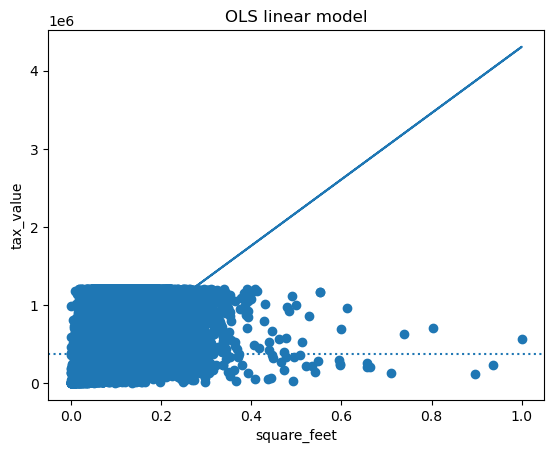

In [15]:
ev.get_feature_target_plot(eval_scaled_df)

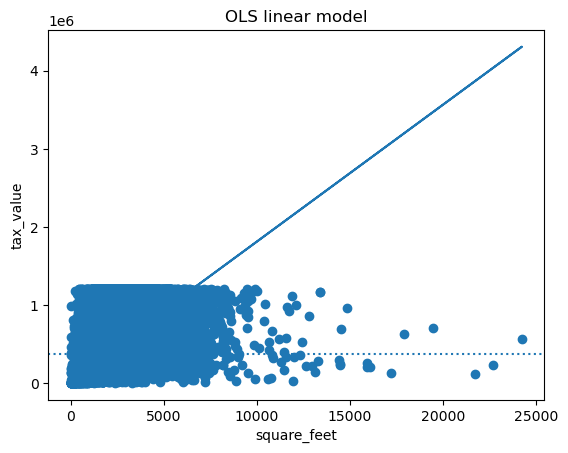

In [16]:
# compare again to non-scaled df
eval_df = train[['square_feet', 'tax_value']]
lr = LinearRegression()
lr.fit(eval_df[['square_feet']], eval_df.tax_value)
eval_df['yhat'] = lr.predict(eval_df[['square_feet']])
ev.get_feature_target_plot(eval_df)
# eval_df.head()

## 3. conclusion: So, bottom line, so far it doesn't appear that scaling helped

## 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [ ]:
def get_reg_model_metrics(y, yhat):
    """
    This function will
    - accept two series y, yhat (target, predicted target values)
    - print these values for the model and for the baseline (mean of y)
        - MSE: Mean Squared Error
        - RMSE: Root Mean Squared Error
        - SSE: Sum of Squared Errors
    - prints these values for model compared to baseline
        - ESS: Explained Sum of Squares
        - TSS: Total Sum of Squares
        - R2: R-squared; the ratio of the Explained Sum of Squares (ESS) to the Total Sum of Squares (TSS)
            - aka the Explained Variance aka the fraction of the variance error explained by model
            - an R2 value closer to 1.0 is better; closer to 0.0 is worse
        """
    df = pd.concat([y, yhat], axis=1)
    df.columns=['y','yhat']
    
    df['yhat_baseline'] = df.y.mean()
    df['residuals'] = df.yhat - df.y
    df['residuals_baseline'] = df.yhat_baseline - df.y
    
    MSE_model = mean_squared_error(df.y, df.yhat)
    RMSE_model = MSE_model ** .5
    SSE_model = MSE_model * len(df)
    
    MSE_baseline = mean_squared_error(df.y, df.yhat_baseline)
    RMSE_baseline = MSE_baseline ** .5
    SSE_baseline = MSE_baseline * len(df)
    
    ESS = sum((df.yhat - df.y.mean())**2)
    TSS = ESS + SSE_model
    R2 = ESS/TSS
    
    results_df = pd.DataFrame({'metric': ['MSE', 'RMSE', 'SSE'],
                               'model_error': [MSE_model, RMSE_model, SSE_model],
                               'baseline_error': [MSE_baseline, RMSE_baseline, SSE_baseline]})
    display(results_df)
    print(f'ESS = {ESS}')
    print(f'TSS = {TSS}')
    print()
    print(f'R^2 (ESS/TSS) = {R2}')

In [17]:
ev.get_reg_model_metrics(eval_df.tax_value, eval_df.yhat)

,metric,model_error,baseline_error
0,MSE,4.295216e+10,5.918398e+10
1,RMSE,2.072490e+05,2.432776e+05
2,SSE,5.239743e+16,7.219866e+16


ESS = 1.9801232802901132e+16
TSS = 7.219865829380187e+16

R^2 (ESS/TSS) = 0.27426039861188156


In [18]:
ev.get_reg_model_metrics(eval_scaled_df.tax_value, eval_scaled_df.yhat)

,metric,model_error,baseline_error
0,MSE,4.295216e+10,5.918398e+10
1,RMSE,2.072490e+05,2.432776e+05
2,SSE,5.239743e+16,7.219866e+16


ESS = 1.9801232802901132e+16
TSS = 7.219865829380187e+16

R^2 (ESS/TSS) = 0.27426039861188156


## 4. conclusion - So, the scaled data was exactly the same (probably has something to do with the fact that we only sent in one feature)

## 5 - 7: I basically did that with the get_reg_model_metrics, just not exactly the way that was asked for. I'll clean that up below.

## 8. Is your model better than the baseline model? 

### YES because all of the model_error metrics are < the baseline_error metrics AND because R^2 is > 0

## 9. Create a file named evaluate.py with 3 functions:
- plot_residuals(y, yhat): creates a residual plot
- regression_errors(y, yhat): returns SSE, ESS, TSS, MSE, RMSE
- baseline_mean_errors(y): returns SSE, MSE, RMSE for baseline
- better_than_baseline(y, yhat): returns True if model performs better than baseline, false otherwise

In [ ]:
# make a function to do plot residuals
def plot_residuals(y, yhat):
    """
    This function will
    - accept two series: y, yhat (should be all continuous variables)
        - y = target variable
        - yhat = predicted y value from some model
    - prints 2 subplots, first is the model residuals, second is the baseline residuals
    """
    df = pd.concat([y, yhat], axis=1)
    cols = df.columns
    
    df.columns=['y','yhat']
    
    df['yhat_baseline'] = df.y.mean()
    df['residuals'] = df.yhat - df.y
    df['residuals_baseline'] = df.yhat_baseline - df.y
    
    plt.figure(figsize=(16,7))
    plt.subplot(1,2,1)
    plt.scatter(df.y, df.residuals)
    plt.axhline(0, ls=':', color='red')
    plt.title('Model Residuals')
    plt.xlabel('y')
    plt.ylabel('yhat - y')
    
    plt.subplot(1,2,2)
    plt.scatter(df.y, df.residuals_baseline)
    plt.axhline(0, ls=':', color='red')
    plt.title('Baseline Residuals')
    plt.xlabel('y')
    plt.ylabel('yhat_baseline - y')
    
    plt.show()

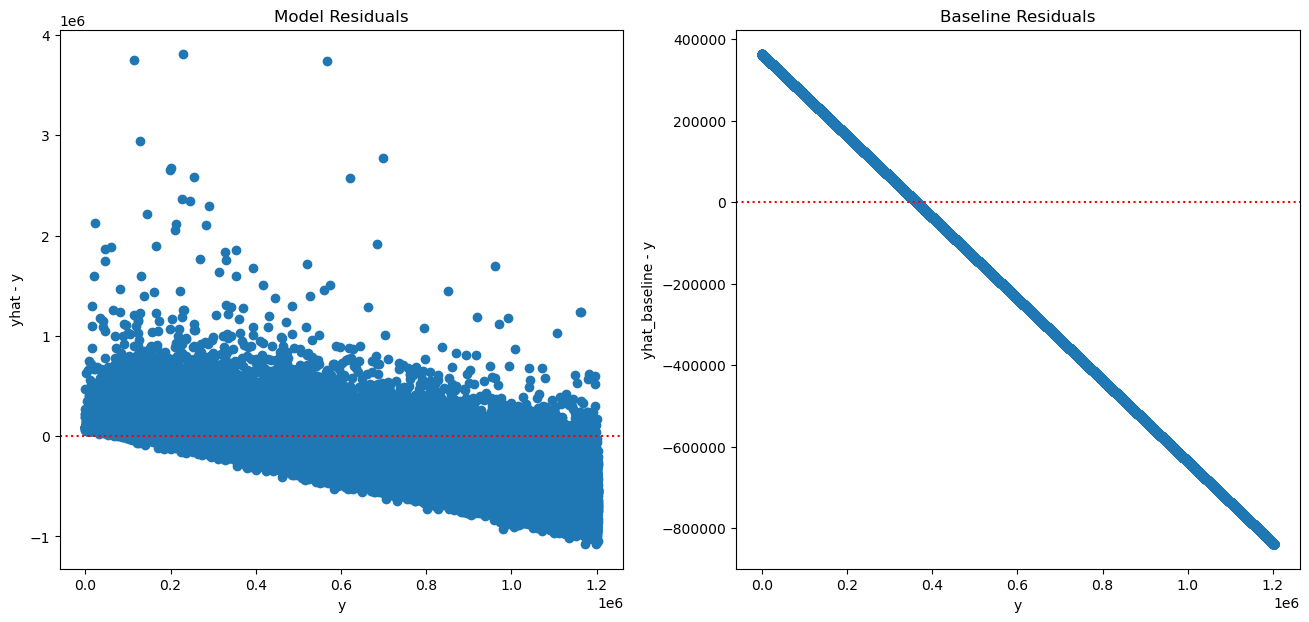

In [19]:
ev.plot_residuals(eval_df.tax_value, eval_df.yhat)

In [ ]:
def regression_errors(y, yhat):
    """
    This function will
    - accpet two series: y, yhat (target value, predicted target value)
    - returns 
        - SSE: Sum of Squared Errors
        - ESS: Explained Sum of Squares
        - TSS: Total Sum of Squares
        - MSE: Mean Squared Error
        - RMSE: Root Mean Squared Error
    """
    df = pd.concat([y, yhat], axis=1)
    df.columns=['y','yhat']
    
    df['yhat_baseline'] = df.y.mean()
    
    MSE_model = mean_squared_error(df.y, df.yhat)
    RMSE_model = MSE_model ** .5
    SSE_model = MSE_model * len(df)
    
    ESS = sum((df.yhat - df.y.mean())**2)
    TSS = ESS + SSE_model
    R2 = ESS/TSS
    
    return SSE_model, ESS, TSS, MSE_model, RMSE_model

In [20]:
ev.regression_errors(eval_df.tax_value, eval_df.yhat)

(5.2397425490900744e+16,
 1.9801232802901132e+16,
 7.219865829380187e+16,
 42952159674.220345,
 207249.0281623061)

In [ ]:
def baseline_mean_errors(y):
    """
    This function will
    - accpet one series: y (target value)
    - returns (for baseline model of the mean of y)
        - SSE: Sum of Squared Errors
        - MSE: Mean Squared Error
        - RMSE: Root Mean Squared Error
    """
    df = pd.DataFrame(y)
    df['yhat_baseline'] = y.mean()
    df.columns=['y','yhat_baseline']
    
    MSE_baseline = mean_squared_error(df.y, df.yhat_baseline)
    RMSE_baseline = MSE_baseline ** .5
    SSE_baseline = MSE_baseline * len(df)
    
    return SSE_baseline, MSE_baseline, RMSE_baseline

In [21]:
ev.baseline_mean_errors(eval_df.tax_value)

(7.219865829380253e+16, 59183982232.837166, 243277.5826763271)

In [ ]:
def better_than_baseline(y, yhat):
    """
    This function will
    - accpet two series: y, yhat (target value, predicted target value)
    - returns True if yhat beats the baseline of the mean of y, False otherwise
    """
    SSE_model, ESS, TSS, MSE_model, RMSE_model = regression_errors(y, yhat)
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y)
    
    # it really doesn't matter which metric we use for this test,
    #   as long as it's the same metric from the model and from the baseline
    
    if (RMSE_model < RMSE_baseline): 
        return True
    else:
        return False

In [22]:
ev.better_than_baseline(eval_df.tax_value, eval_df.yhat)

True

# Exercise complete